In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the dataset and visualize

In [2]:
num_runs = 50000       # This is the total dataset size
num_fields = 3
coords_per_side = 21   # This is how many mesh points are on each side
boundary_length = coords_per_side*4 - 4       # should be 80
mesh_length = coords_per_side*coords_per_side # should be 441

In [3]:
# Change to data folder path
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the Mesh Coordinates
# These are the X,Y coordinates for each mesh point
MCs = np.loadtxt(data_folder + 'meshCoords.txt')
# Load the Boundary Coordinates
# These are the X,Y coordinates just for each point on the boundary
BCs = np.loadtxt(data_folder + 'boundaryCoords.txt')
# Load the Field Solutions
# These are the solved scalar and vector fields
solutions = np.load(data_folder + 'solutions.npy')
# Load the Boundary Conditions
# These are the originally applied Boundary Conditions
inputs = np.load(data_folder + 'inputs.npy')

In [5]:
solutions.shape

(50000, 3, 441)

In [6]:
inputs.shape

(50000, 3, 80)

/usr/local/lib/python3.11/dist-packages/matplotlib/quiver.py:676: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


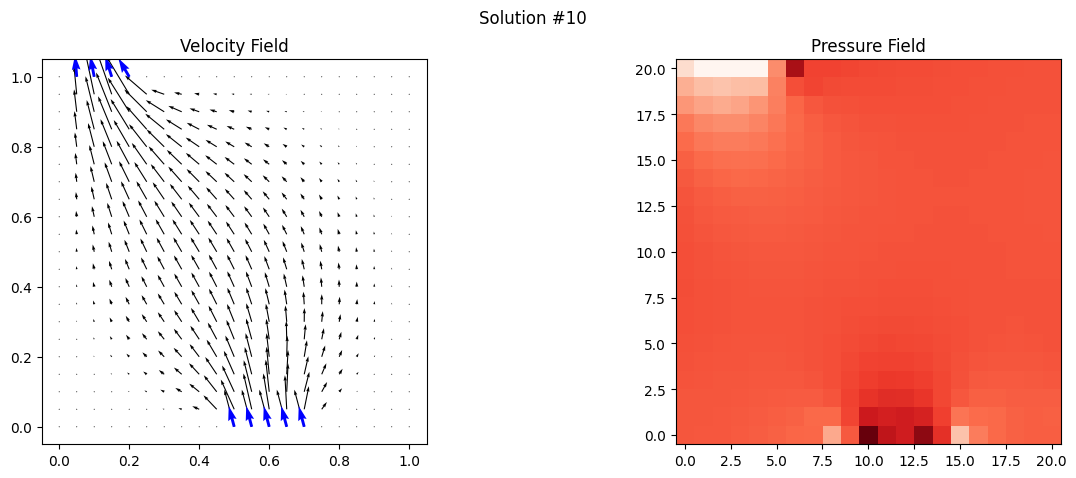

In [7]:
run_id = 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d}'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solutions[run_id,1,:],solutions[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs[run_id,1,i],inputs[run_id,2,i],color='b')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solutions[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')

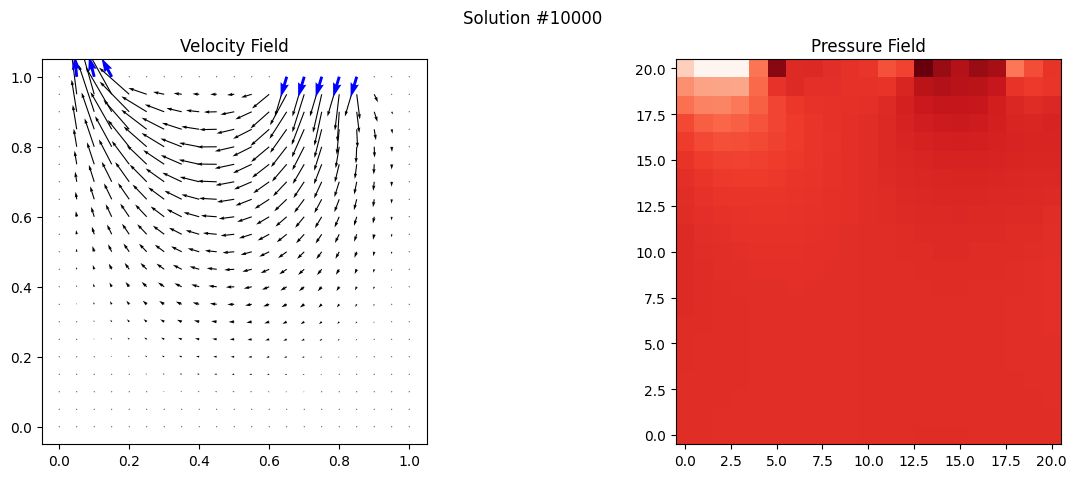

In [8]:
run_id = 10000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d}'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solutions[run_id,1,:],solutions[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs[run_id,1,i],inputs[run_id,2,i],color='b')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solutions[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')

# Pre-processing

In [9]:
inputs = np.nan_to_num(inputs, nan = 0)
solution = solutions.copy()
solution[(solution < 1e-3) & (solution > -1e-3)] = 0

In [10]:
inputs_flat = inputs.reshape(inputs.shape[0], inputs.shape[1]*inputs.shape[2])
solution_flat = solution.reshape(solution.shape[0], solution.shape[1]*solution.shape[2])

In [11]:
solution_scaler = StandardScaler().fit(solution_flat)
solution_scaled = solution_scaler.transform(solution_flat)
inputs_scaler = StandardScaler().fit(inputs_flat)
inputs_scaled = inputs_scaler.transform(inputs_flat)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(inputs_scaled, solution_scaled, test_size=0.2, random_state=42)

In [13]:
X_train.shape

(40000, 240)

In [14]:
y_train.shape

(40000, 1323)

# Model initialization and training

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1080, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1])  # Output layer
])

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)

In [17]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

In [18]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks = [reduce_lr, callback])

Epoch 1/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3587 - mse: 0.3587 - val_loss: 0.0877 - val_mse: 0.0877 - learning_rate: 0.0010
Epoch 2/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0684 - val_mse: 0.0684 - learning_rate: 0.0010
Epoch 3/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0444 - val_mse: 0.0444 - learning_rate: 0.0010
Epoch 4/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0370 - val_mse: 0.0370 - learning_rate: 0.0010
Epoch 5/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0346 - val_mse: 0.0346 - learning_rate: 0.0010
Epoch 6/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0316 - val_mse: 0.0316 - learning_rate: 0.0010
Epoch 7/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0281 - val_mse: 0.0281 - learnin

# Model evaluation and predictions

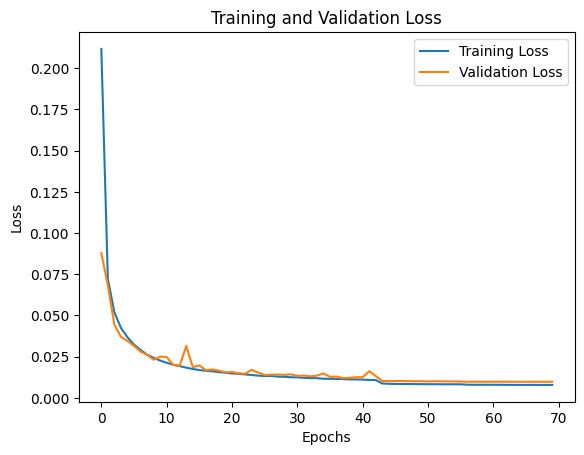

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [21]:
inputs_test = inputs_scaler.inverse_transform(X_test)
inputs_test[(inputs_test < 1e-3) & (inputs_test > -1e-3)] = 0
inputs_test_plot = inputs_test.reshape(X_test.shape[0], inputs.shape[1], inputs.shape[2])

solution_test = solution_scaler.inverse_transform(y_test)
solution_test_plot = solution_test.reshape(y_test.shape[0], solution.shape[1], solution.shape[2])

solution_pred = solution_scaler.inverse_transform(y_pred)
solution_pred_plot = solution_pred.reshape(y_pred.shape[0], solution.shape[1], solution.shape[2])

/usr/local/lib/python3.11/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.11/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


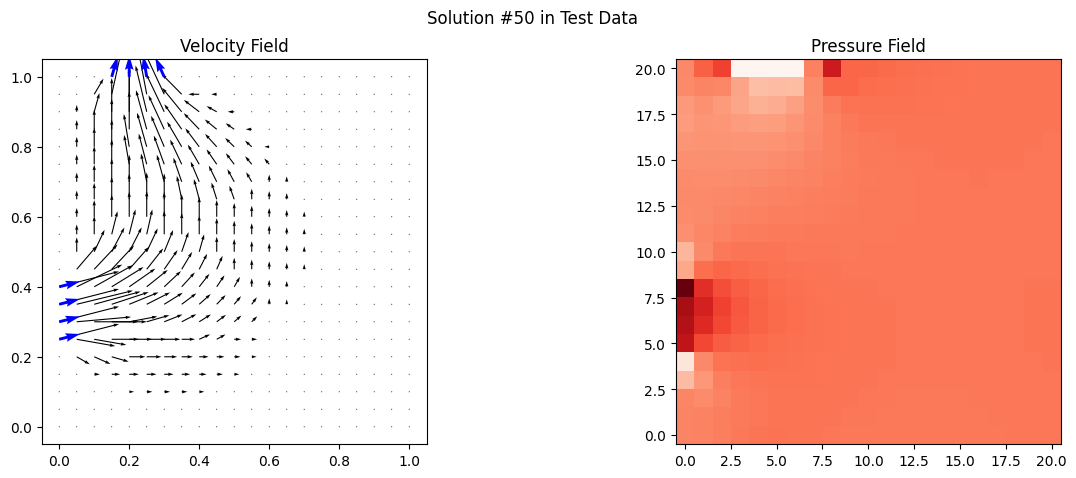

In [22]:
run_id = 50

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d} in Test Data'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solution_test_plot[run_id,1,:],solution_test_plot[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs_test_plot[run_id,1,i],inputs_test_plot[run_id,2,i],color='b')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solution_test_plot[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')

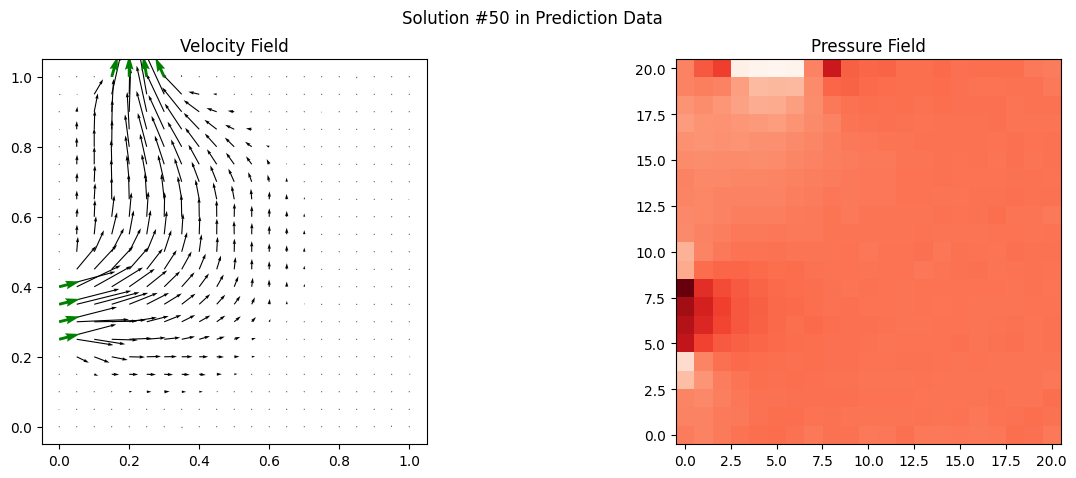

In [23]:
run_id = 50

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d} in Prediction Data'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solution_pred_plot[run_id,1,:],solution_pred_plot[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs_test_plot[run_id,1,i],inputs_test_plot[run_id,2,i],color='g')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solution_pred_plot[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')

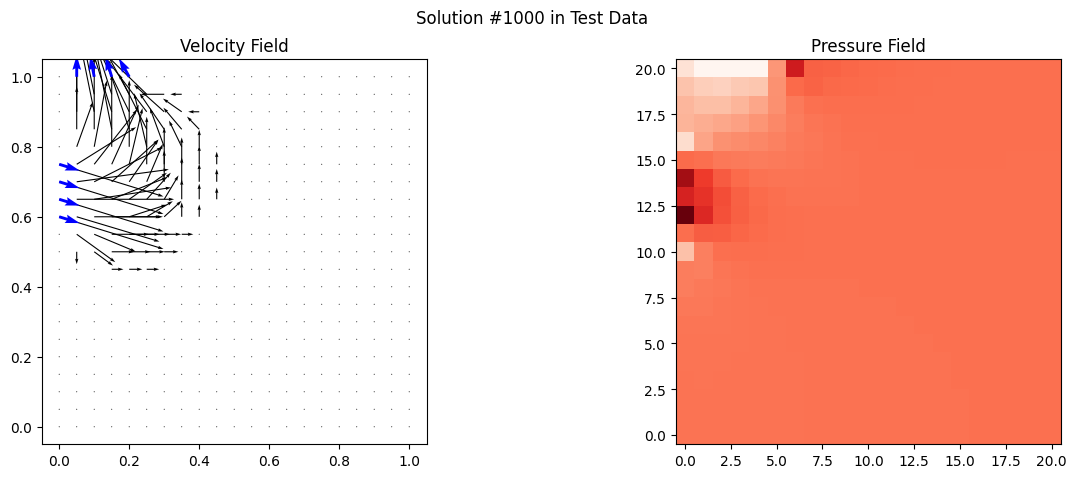

In [24]:
run_id = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d} in Test Data'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solution_test_plot[run_id,1,:],solution_test_plot[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs_test_plot[run_id,1,i],inputs_test_plot[run_id,2,i],color='b')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solution_test_plot[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')

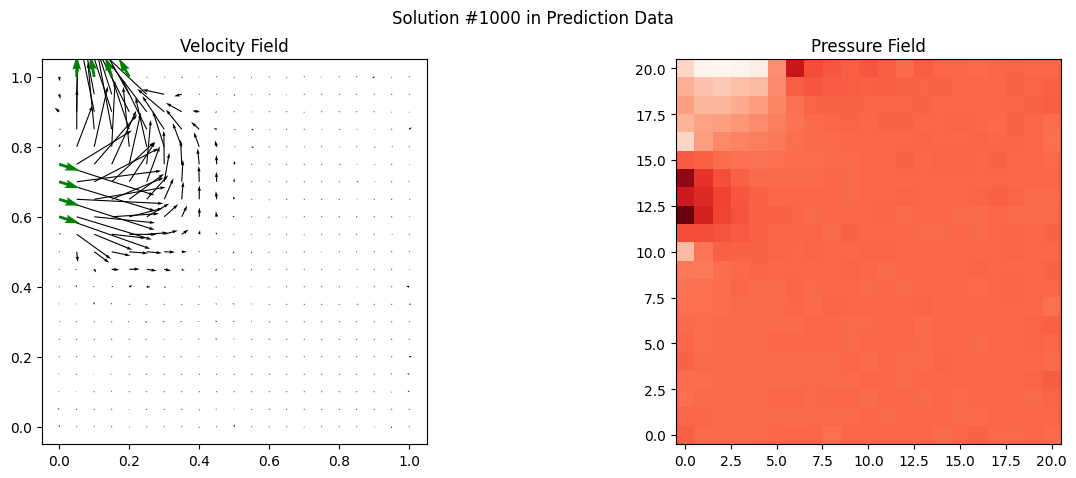

In [25]:
run_id = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d} in Prediction Data'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solution_pred_plot[run_id,1,:],solution_pred_plot[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs_test_plot[run_id,1,i],inputs_test_plot[run_id,2,i],color='g')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solution_pred_plot[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')

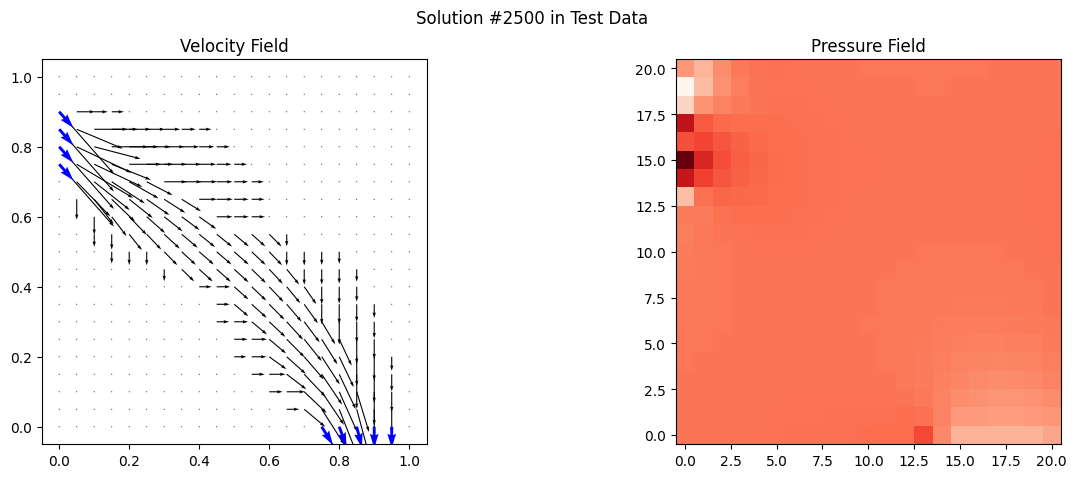

In [26]:
run_id = 2500

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d} in Test Data'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solution_test_plot[run_id,1,:],solution_test_plot[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs_test_plot[run_id,1,i],inputs_test_plot[run_id,2,i],color='b')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solution_test_plot[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')

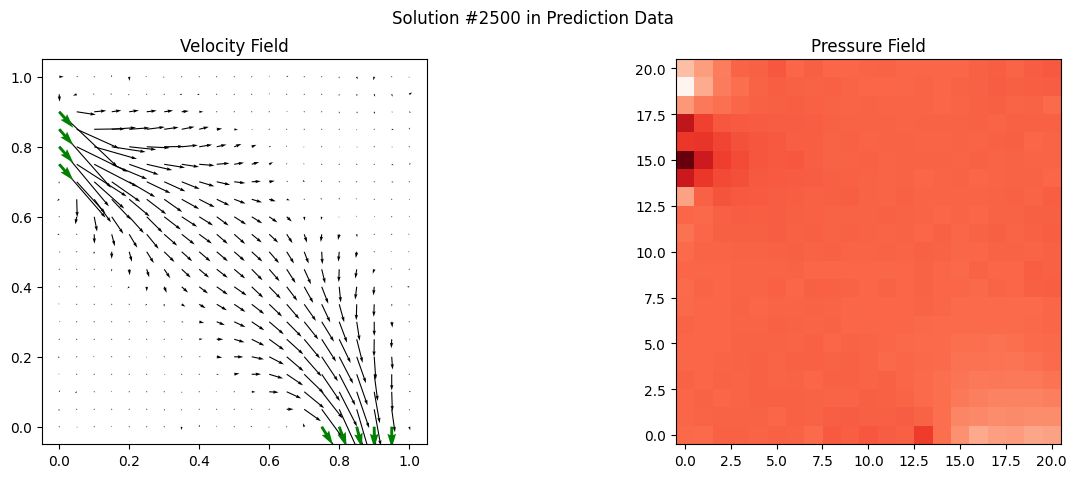

In [27]:
run_id = 2500

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Solution #{:d} in Prediction Data'.format(run_id))

# Plot the Velocity Field
ax1.quiver(MCs[:,0],MCs[:,1],solution_pred_plot[run_id,1,:],solution_pred_plot[run_id,2,:])
ax1.set_title('Velocity Field')
for i,(x,y) in enumerate(BCs):
    ax1.quiver(x,y,inputs_test_plot[run_id,1,i],inputs_test_plot[run_id,2,i],color='g')
    plt.plot(x,y)
ax1.set_aspect('equal')


# Plot the Pressure Field
ax2.imshow(solution_pred_plot[run_id,0,:].reshape(coords_per_side,coords_per_side),origin='lower',cmap = 'Reds')
ax2.set_title('Pressure Field');
ax2.set_aspect('equal')